<a href="https://colab.research.google.com/github/yuhui-0611/ESAA/blob/main/ESAA_YB_WEEK07_1_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9. 분류 실습 - 캐글 산탄데르 고객 만족 예측**

< 산탄데르 고객 만족 예측 분석 >

- 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부 예측
- 클래스 레이블 명 = TARGET
- TARGET 값이 1이면 불만을 가진 고객, 0이면 만족한 고객
- 대부분이 만족이고 불만족인 데이터는 일부일 것이기에 정확도 수치보다는 ROC-AUC로 모델 성능 평가하는 것이 더 적합
> 예를 들어, 100명 중 95명이 만족했고 5명이 불만족했다면 만족이라고 예측할 확률은 95%로 정확도가 95%가 됨, 하지만 ROC 커브는 단순히 맞췄는지 못 맞췄는지에만 초점을 맞추지 않고 만족과 불만족을 얼마나 잘 분류할 수 있는가를 평가함, 즉, 불만족 고객을 얼마나 잘 구별할 수 있는가를 수치로 보여주기에 ROC가 더 적합함

In [ ]:
!pip install xgboost==1.7.6
!pip install lightgbm==4.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.5
    Uninstalling xgboost-3.0.5:
      Successfully uninstalled xgboost-3.0.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **데이터 전처리**

In [ ]:
cust_df = pd.read_csv('/content/drive/MyDrive/ESAA/train.c.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


NULL X

In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3의 min이 -999999여서 조사

In [ ]:
print(cust_df.var3.value_counts()[:10])

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: count, dtype: int64


-999999가 116개 있는데, 이는 숫자형이고 다른 값에 비해 너무 편차가 심해, 이를 가장 값이 많은 2로 변환

In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)

# ID피처는 단순 식별자이므로 드롭
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리
# 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:', X_features.shape)

피처 데이터 shape: (76020, 369)


비대칭 데이터이기에 클래스인 Target 값 분포도가 학습과 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET 값 분포가 원본 데이터와 유사하게 전체의 4% 정보의 불만족 값으로 만들어짐

- XGBoost는 반복을 통해 모델을 점점 개선해가는데, 너무 많이 학습시키면 과적합의 위험이 있기에 검증용 데이터를 따로 지정
- 이를 통해 중간중간 성능을 체크하다가 더이상 성능이 좋아지지 않으면 자동으로 학습을 중단

In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

## **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

XGBoost 학습 모델 생성 후 예측 결과 ROC AUC로 평가

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
# 검증 데이터에서 100번 연속으로 성능이 개선되지 않으면 학습을 중단
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

# XGBoost 모델(xgb_clf)이 각 클래스에 속할 확률을 예측 → 두 번째 열(즉, class=1의 확률)만 선택
# 즉, predict_proba(X_test)[:,1] → 모델이 예측한 "불만족(1)" 확률
# 'macro' = 모든 클래스에 동일한 가중치로 평균을 냄
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82058	validation_1-auc:0.81873
[1]	validation_0-auc:0.82427	validation_1-auc:0.82085
[2]	validation_0-auc:0.82489	validation_1-auc:0.82124
[3]	validation_0-auc:0.82687	validation_1-auc:0.82436
[4]	validation_0-auc:0.82886	validation_1-auc:0.82462
[5]	validation_0-auc:0.82927	validation_1-auc:0.82508
[6]	validation_0-auc:0.83167	validation_1-auc:0.82748
[7]	validation_0-auc:0.83206	validation_1-auc:0.82864
[8]	validation_0-auc:0.83247	validation_1-auc:0.82796
[9]	validation_0-auc:0.83370	validation_1-auc:0.82783
[10]	validation_0-auc:0.83387	validation_1-auc:0.82783
[11]	validation_0-auc:0.83717	validation_1-auc:0.82881
[12]	validation_0-auc:0.83960	validation_1-auc:0.83023
[13]	validation_0-auc:0.83924	validation_1-auc:0.82882
[14]	validation_0-auc:0.84196	validation_1-auc:0.83103
[15]	validation_0-auc:0.84256	validation_1-auc:0.83253
[16]	validation_0-auc:0.84314	validation_1-auc:0.83254
[17]	validation_0-auc:0.84425	validation_1-auc:0.83171
[18]	validation_0-au

In [ ]:
from hyperopt import hp

# max_dapth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환
def objective_func(search_space):
    # 수행 시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'])

    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []

    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)

    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
      # kf.spllit(X_trian)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
      X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
      X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

      # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
      xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                  eval_set=[(X_tr, y_tr), (X_val, y_val)])

      # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
      score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
      roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin 함수를 호출
# max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=xgb_search_space,
            max_evals=50, # 최대 반복 횟수를 지정
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

Streaming output truncated to the last 5000 lines.
[20]	validation_0-auc:0.90086	validation_1-auc:0.82793
[21]	validation_0-auc:0.90190	validation_1-auc:0.82629
[22]	validation_0-auc:0.90439	validation_1-auc:0.82729
[23]	validation_0-auc:0.90507	validation_1-auc:0.82820
[24]	validation_0-auc:0.90590	validation_1-auc:0.82771
[25]	validation_0-auc:0.90669	validation_1-auc:0.82847
[26]	validation_0-auc:0.90836	validation_1-auc:0.82965
[27]	validation_0-auc:0.90970	validation_1-auc:0.82947
[28]	validation_0-auc:0.91131	validation_1-auc:0.83014
[29]	validation_0-auc:0.91183	validation_1-auc:0.83063
[30]	validation_0-auc:0.91203	validation_1-auc:0.83035
[31]	validation_0-auc:0.91254	validation_1-auc:0.83014
[32]	validation_0-auc:0.91333	validation_1-auc:0.82944
[33]	validation_0-auc:0.91352	validation_1-auc:0.82935
[34]	validation_0-auc:0.91388	validation_1-auc:0.82896
[35]	validation_0-auc:0.91421	validation_1-auc:0.82882
[36]	validation_0-auc:0.91417	validation_1-auc:0.82852
[37]	validatio

colsamplbe_bytree = 약 0.5749

learning_rate = 약 0.1514

max_depth = 5.0

min_child_weight = 6.0


이렇게 도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier 재학습 & ROC_AUC 측정

In [ ]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = round(best['learning_rate'],5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 100,
            eval_metric = "auc", eval_set = [(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81701	validation_1-auc:0.81732
[1]	validation_0-auc:0.81367	validation_1-auc:0.80153
[2]	validation_0-auc:0.82607	validation_1-auc:0.81629
[3]	validation_0-auc:0.83190	validation_1-auc:0.82448
[4]	validation_0-auc:0.83338	validation_1-auc:0.82803
[5]	validation_0-auc:0.83293	validation_1-auc:0.82323
[6]	validation_0-auc:0.83074	validation_1-auc:0.81871
[7]	validation_0-auc:0.83423	validation_1-auc:0.82264
[8]	validation_0-auc:0.83718	validation_1-auc:0.82593
[9]	validation_0-auc:0.83639	validation_1-auc:0.82314
[10]	validation_0-auc:0.83365	validation_1-auc:0.81931
[11]	validation_0-auc:0.83686	validation_1-auc:0.82374
[12]	validation_0-auc:0.83947	validation_1-auc:0.82572
[13]	validation_0-auc:0.83790	validation_1-auc:0.82117
[14]	validation_0-auc:0.83977	validation_1-auc:0.82284
[15]	validation_0-auc:0.83832	validation_1-auc:0.82046
[16]	validation_0-auc:0.83674	validation_1-auc:0.81826
[17]	validation_0-auc:0.83557	validation_1-auc:0.81388
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

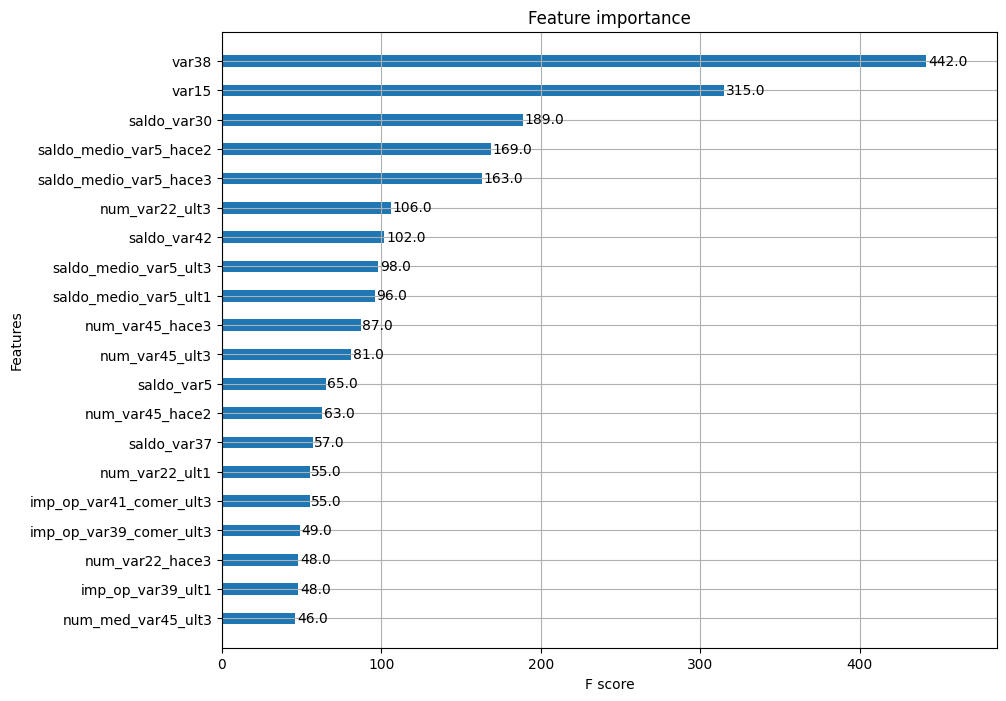

In [ ]:
# 중요도
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

## **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

In [ ]:
from lightgbm import LGBMClassifier, early_stopping

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)], eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 2121, number of negative: 52613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14060
[LightGBM] [Info] Number of data points in the train set: 54734, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038751 -> initscore=-3.211076
[LightGBM] [Info] Start training from score -3.211076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.893265	training's binary_logloss: 0.118209	valid_1's auc: 0.84314	valid_1's binary_logloss: 0.139368
ROC AUC: 0.8381


Hyperopt를 이용해 다양한 하이퍼 파라미터에 대한 튜닝 수행
- 튜닝 대상 : num_leves, max_depth, min_child_samples, subsample, learning_rate

In [ ]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth':hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples':hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample':hp.uniform('subsample', 0.7, 1),
                     'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['learning_rate'],
                            learning_rate=search_space['learning_rate'])

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf,split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr=X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val=X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=30)], eval_metric="auc",
                 eval_set=[(X_tr, y_tr), (X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
    score=roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
  return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best=fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.88765	training's binary_logloss: 0.121808	valid_1's auc: 0.831519	valid_1's binary_logloss: 0.135868
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081206 seconds.
You can set `force_row_wise=true` 

learning_rate = 약 0.08592

max_depth = 121.0

min_child_samples = 69.0

num_leaves = 41.0

subsample = 0.91489

이제 이들 하이퍼 파라미터를 이용하여 LightGBM을 학습 & 테스트 데이터 세트에서 ROC-AUC 평가

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)],
             eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 2121, number of negative: 52613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13766
[LightGBM] [Info] Number of data points in the train set: 54734, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038751 -> initscore=-3.211076
[LightGBM] [Info] Start training from score -3.211076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's auc: 0.889935	training's binary_logloss: 0.119671	valid_1's auc: 0.843018	valid_1's binary_logloss: 0.139443
ROC AUC: 0.8455


LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 0.8446으로 측정됨

# **10. 분류 실습 - 캐글 신용카드 사기 검출**

## **언더 샘플링과 오버 샘플링의 이해**

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있음

이는 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 발생

즉, 이상 레이블을 가지는 데이터 건수는 매우 적어서 제대로 다양한 유형을 학습하지 못하는 반면, 정상 레이블을 가진 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움

지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요

대표적으로 **오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법**이 있으며, ***오버 샘플링 방식***이 예측 성능상 조금 유리한 경우가 많아 상대적으로 더 많이 사용됨

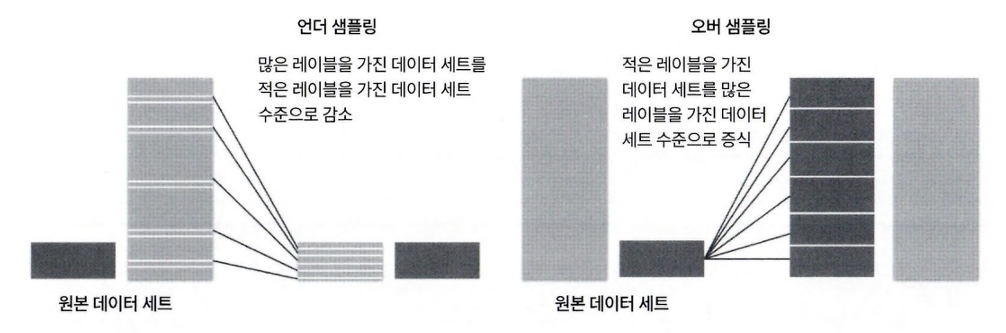

< 언더 샘플링 >
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 즉 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식
- 이렇게 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시켜서 정상 레이블의 경우 제대로 된 학습을 수행할 수 없는 문제가 발생할 수도 있으므로 유의

< 오버 샘플링 >
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
- 대표적으로 **SMOTE(Synthetic Minority Over-sampling Technique) 방법**이 있음
- SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

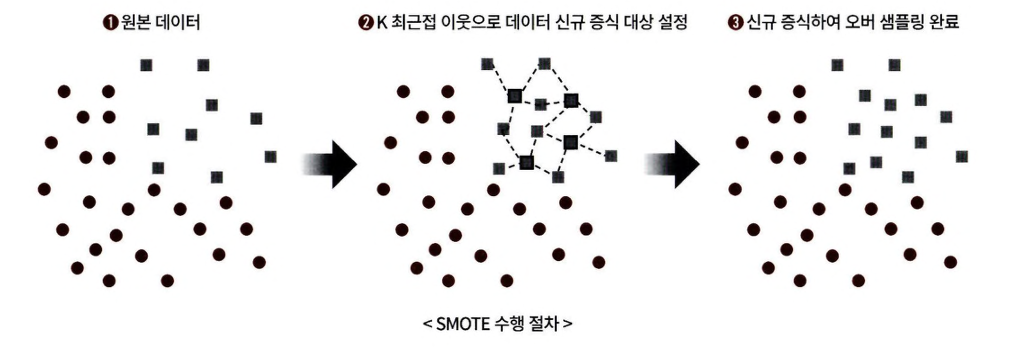

In [ ]:
%pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
card_df = pd.read_csv('/content/drive/MyDrive/ESAA/creditcard.csv',engine='python')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


creditcard.csv의 V로 시작하는 피처들의 의미는 알 수 X

Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로 큰 의미가 없기에 제거

Amount 피처는 신용카드 트랜잭션 금액

Class는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션

In [ ]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

결측치 X

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)

  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]

  # train_test_split()으로 학습과 테스트 데이터 분할
  # stratify = y_target으로 Stratified 기반 분할
  # stratify=y는 데이터를 나눌 때 y_target(=정답 라벨)의 비율을 유지하라는 뜻
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                      random_state=0, stratify = y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1： {3:.4f}, AUC：{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [ ]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델을 만들 때,
# 학습 반복 횟수(Iteration)의 최대값을 1000으로 설정
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]  # 클래스가 1인 것만 추출

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1： 0.7194, AUC：0.9741


In [ ]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

## **데이터 분포도 변환 후 모델 학습/예측/평가**

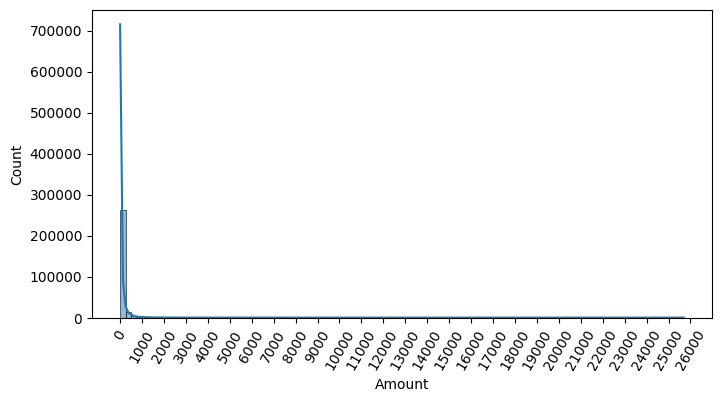

In [ ]:
import seaborn as sns

# Amount 값의 분포도
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분

26,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 띰

In [ ]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):

  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))

  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LoghtGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1： 0.7294, AUC：0.9706
### LoghtGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀의 경우는 정밀도와 재현율이 오히려 조금 저하되었고, LightGBM의 경우는 약간 정밀도와 재현율이 저하되었지만 큰 성능상의 변경은 없음

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()

  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])

  # 새로 계산된 로그 변환 결과(amount_n)를 데이터프레임의 맨 앞(0번째 열)에 삽입
  df_copy.insert(0,'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법

원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 줌

In [ ]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1： 0.7120, AUC：0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

로지스틱 회귀의 경우 원본 데이터 대비 정밀도는 향상되었지만 재현율은 저하됨

LightGBM의 경우 재현율이 향상됨

레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여 줌

## **이상치 데이터 제거 후 모델 학습/예측/평가**

이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불림

이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉬움

이상치를 찾는 방법은 여러 가지가 있지만, 이 중에서 IQR(Inter Quantile Range) 방식을 적용

IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화 가능

- IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것

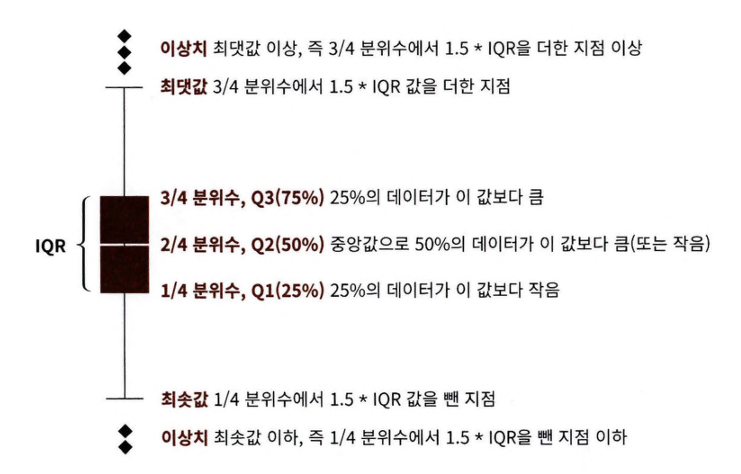

<Axes: >

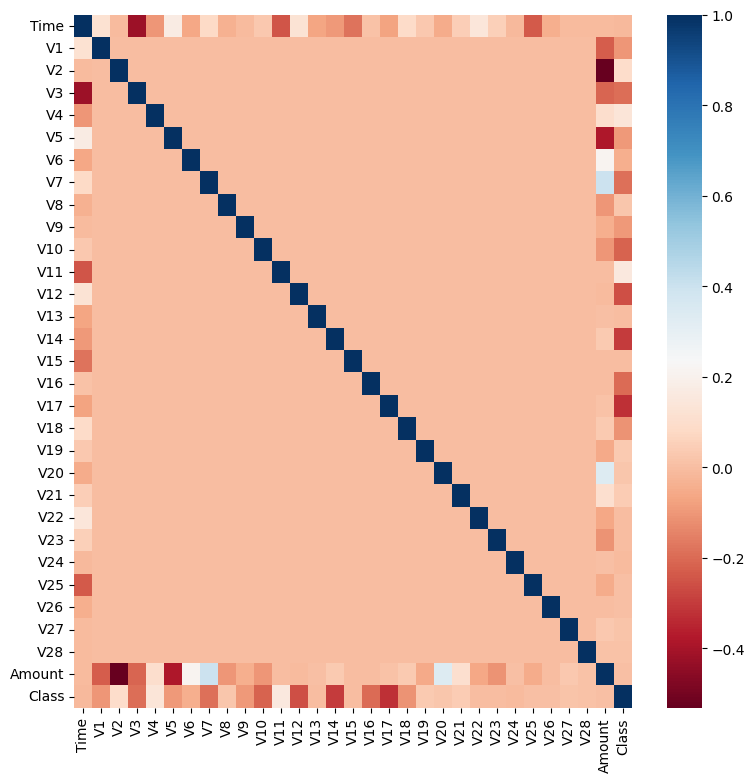

In [ ]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

상관관계 히트맵에서 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처 = V14와 V17

IQR을 이용해 이상치를 검출하는 함수를 생성

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):

  # froud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
  return outlier_index

V14 칼럼에서 이상치 데이터 찾기

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
# get_precessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)

  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1： 0.7568, AUC：0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

## **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링 해야함

검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없음

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398.040건으로 데이터가 증식

SMOTE 적용 후 레이블 값이 0과 1 의 분포가 동일하게 199,020 건으로 생성

In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1： 0.1022, AUC：0.9736


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하됨

재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없음

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

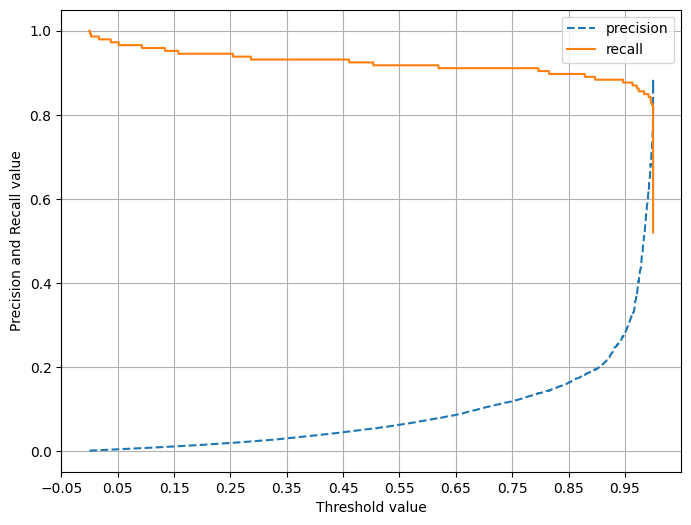

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐

분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 됨

정밀도는 이전의 96.03%보다 낮은 91.18%

SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적

때문에 정밀도 지표보다는 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE를 적용하면 좋음

좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식

< 로지스틱 회귀와 LightGBM 적용 결과 >

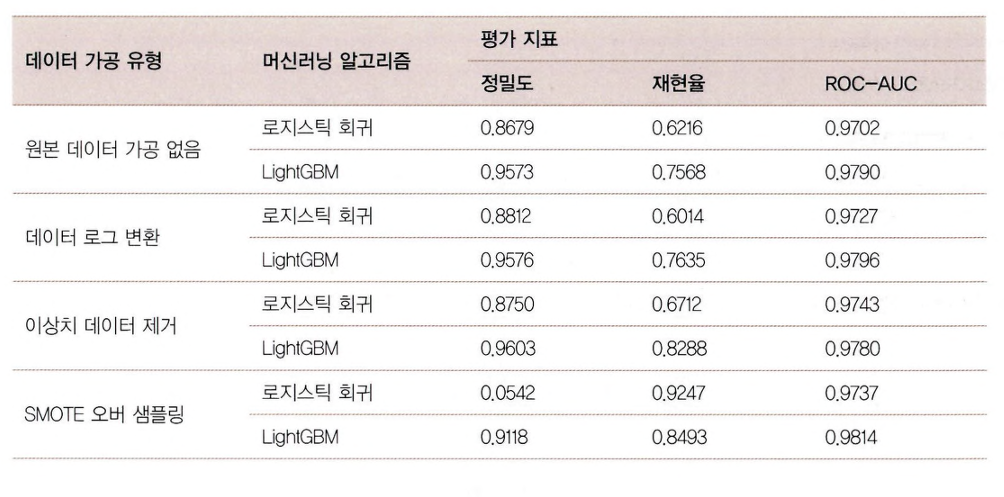